In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay


# Import NLTK and download the data

In [2]:
import nltk
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/gomes/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

# Load Twitter data

In [3]:
from nltk.corpus import twitter_samples
tweets_pos = twitter_samples.strings('positive_tweets.json')     #  5000
tweets_neg = twitter_samples.strings('negative_tweets.json')     #  5000
tweets_all = tweets_pos + tweets_neg                             # 10000

In [4]:
labels_pos = np.ones ((len(tweets_pos),1), dtype=np.int8)  # positive labels (1)
labels_neg = np.zeros((len(tweets_neg),1), dtype=np.int8)  # negative labels (0)
labels_all = np.append(labels_pos,labels_neg)              # all labels

In [5]:
pd.DataFrame(data={'tweet':tweets_all,'label':labels_all})

,tweet,label
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,@DespiteOfficial we had a listen last night :)...,1
3,@97sides CONGRATS :),1
4,yeaaaah yippppy!!! my accnt verified rqst has...,1
...,...,...
9995,I wanna change my avi but uSanele :(,0
9996,MY PUPPY BROKE HER FOOT :(,0
9997,where's all the jaebum baby pictures :((,0
9998,But but Mr Ahmad Maslan cooks too :( https://t...,0


# Test train split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets_all, labels_all,
                                                    test_size=0.25, 
                                                    random_state=243824)

len(X_train), len(X_test), len(y_train), len(y_test)

(7500, 2500, 7500, 2500)

# Process

## 1) Tokenize

In [8]:
TweetTokenizer?

In [7]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
X_train_tok = [tokenizer.tokenize(tweet) for tweet in X_train]

In [13]:
n = 47
X_train[n],X_train_tok[n]

("@hawkins_g omg you're so mean, he's fine :(",
 ['omg', "you're", 'so', 'mean', ',', "he's", 'fine', ':('])

In [29]:
X_train[89]

'@TOBMAST3R @inspchin @koeitecmoeurope @TanikoHorigome @GoldxFierce @Kronin1 @Addictrian @chako33 @MatthewRumple thx Tobi-bro! :D'

In [28]:
X_train_tok[89]

['thx', 'tobi-bro', '!', ':D']

## 2) Remove stopwords

In [30]:
from nltk.corpus import stopwords
swords = stopwords.words('english')

X_train_tok_nostop = []
for tweet in X_train_tok:
    words = [word for word in tweet if word not in swords]
    X_train_tok_nostop.append(words)

In [33]:
X_train_tok_nostop[89]

['thx', 'tobi-bro', '!', ':D']

## 2) Stemming

In [31]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

X_train_tok_nostop_stem = []
for tweet in X_train_tok_nostop:
    words = [stemmer.stem(word) for word in tweet]
    X_train_tok_nostop_stem.append(words)

In [32]:
X_train_tok_nostop_stem[89]

['thx', 'tobi-bro', '!', ':d']


# Put it all into a function

In [35]:
def preprocess_text(tweets):

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    stemmer = PorterStemmer()
    swords = stopwords.words('english')

    X = []
    for tweet in tweets:
        tokens = tokenizer.tokenize(tweet)
        X.append([stemmer.stem(word) for word in tokens if word not in swords]) 
        
    return X

In [36]:
X_train_pp = preprocess_text(X_train)

# Word frequencies

In [37]:
unique_words = set()
for tweet in X_train_pp:
    unique_words.update(tweet)
len(unique_words)

10225

In [38]:
words_pos = []
words_neg = []

for tweet, label in zip(X_train_pp,y_train):
    if label==0:
        words_neg.extend(tweet)
    else:
        words_pos.extend(tweet)
        
unique_words = np.array(list(unique_words))
words_pos = np.array(words_pos)
words_neg = np.array(words_neg)

print(words_pos[:6])
print(words_neg[:6])

['stat' 'day' 'arriv' '.' '1' 'new']
['one' 'want' 'go' 'ant' 'man' ':(']


In [49]:
len(words_pos) + len(words_neg)

61487

In [39]:
word_count = { w: [0,0] for w in unique_words }
for word in words_pos:
    word_count[word][1] += 1
for word in words_neg:
    word_count[word][0] += 1

In [40]:
word_count_matrix = np.array([val for key,val in word_count.items()])

ind_neg = np.argsort(word_count_matrix[:,0])
ind_pos = np.argsort(word_count_matrix[:,1])

print(unique_words[ind_neg[-4:]])
print(unique_words[ind_pos[-4:]])

word_count[':(']

['!' '.' '(' ':(']
[',' '.' '!' ':)']


[3442, 1]

In [41]:
word_count['.']

[813, 980]

# Plot a sample

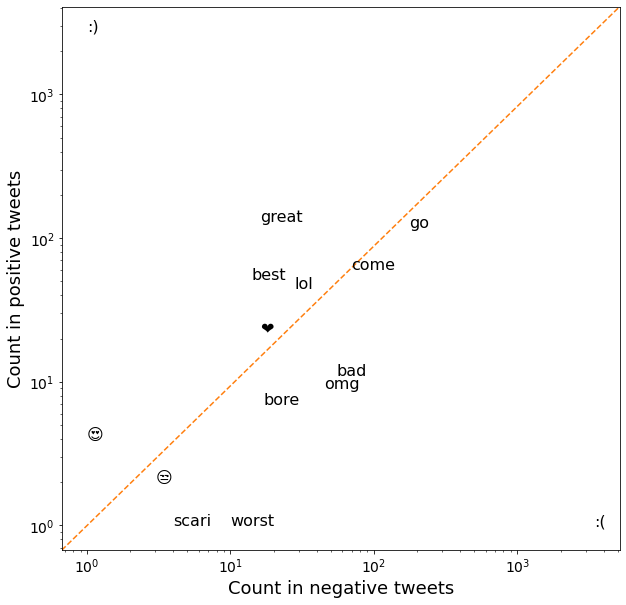

In [44]:
keys = ['❤', '😍', '😒', ':)', ':(','great','bad','scari','bore','best','worst','omg','lol','come','go']\

A = np.array([word_count[key] for key in keys])

plt.figure(figsize=(10,10))
plt.loglog(A[:,0],A[:,1],'.',markersize=0)  
xlim = plt.xlim()
ylim = plt.ylim()
plt.loglog(xlim,ylim,'--')
plt.xlim(xlim)
plt.ylim(ylim)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Count in positive tweets", fontsize=18)
plt.xlabel("Count in negative tweets", fontsize=18)

for i in range(0, len(keys)):
    plt.annotate(keys[i], A[i,:], fontsize=16)

# Full bag of words

In [56]:
bow_matrix_train = np.zeros((len(X_train_pp),len(unique_words)))
for i, tweet in enumerate(X_train_pp):
    for word in tweet:
        bow_matrix_train[i,unique_words==word] += 1

In [74]:
np.sum(bow_matrix_train!=0)/np.prod(bow_matrix_train.shape)

0.0007450105949470253

76687500

In [58]:
df = pd.DataFrame(data=bow_matrix_train,columns=unique_words)
df

,promot,http://t.co/gnw1lwjfk1,meee,rted,heechul,http://t.co/q404e06zet,teret,might,didnt,http://t.co/tchmtf8om4,...,2-0,x',tunaita,ahhh,2am,http://t.co/mnykjgxbpa,yunni,realli,yisss,jennyjean
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Test data

In [59]:
X_test_pp = preprocess_text(X_test)
bow_matrix_test = np.zeros((len(X_test_pp),len(unique_words)))
for i, tweet in enumerate(X_test_pp):
    for word in tweet:
        if word in unique_words:
            bow_matrix_test[i,unique_words==word] += 1

# Naive Bayes

In [60]:
alpha = 1 # smooting fact
M = bow_matrix_train.shape[1]

# indices of positive tweets
ind_pos = y_train==1

# Word count for each term i in positive and negative tweets
N_pos_i = bow_matrix_train[ ind_pos,:].sum(axis=0)
N_neg_i = bow_matrix_train[~ind_pos,:].sum(axis=0)

# Total word count in positive and negative tweets
N_pos = N_pos_i.sum()
N_neg = N_neg_i.sum()

# Coefficients for positive and negative classes
logp_pos_i = np.log( (N_pos_i+alpha)/(N_pos+M*alpha) )
logp_neg_i = np.log( (N_neg_i+alpha)/(N_neg+M*alpha) )

# Intercepts for positive and negative classes
logp_pos = np.log( N_pos/(N_pos + N_neg) )
logp_neg = np.log( N_neg/(N_pos + N_neg) )

print(logp_pos_i)

[ -9.03142899  -9.94771973 -10.64086691 ...  -6.5804239   -9.94771973
  -9.94771973]


In [61]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB(alpha=1.0, fit_prior=False).fit(bow_matrix_train,y_train)

In [62]:
print(naive_bayes.feature_log_prob_[1])

[ -9.03142899  -9.94771973 -10.64086691 ...  -6.5804239   -9.94771973
  -9.94771973]


In [63]:
naive_bayes.score(bow_matrix_test, y_test)

0.998


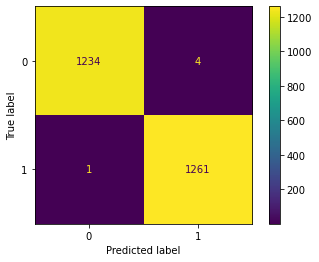

In [66]:
ConfusionMatrixDisplay.from_estimator(naive_bayes, bow_matrix_test, y_test)

# Logistic regression

In [67]:
from sklearn.linear_model import LogisticRegression
lr_full = LogisticRegression().fit(bow_matrix_train,y_train)

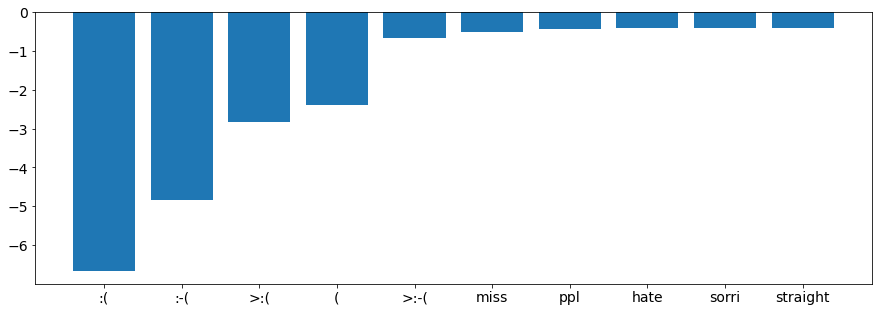

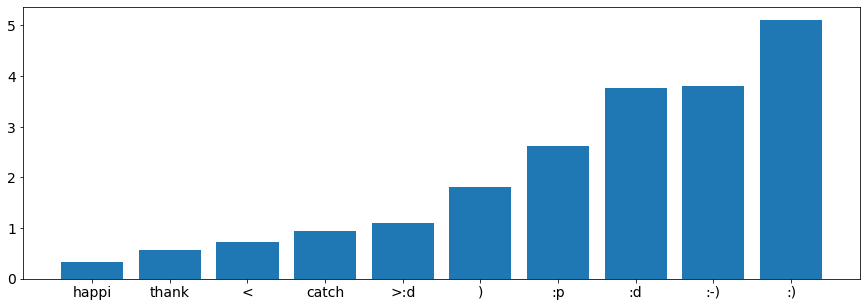

In [68]:
ind = np.argsort(lr_full.coef_[0])

n = 10
plt.figure(figsize=(15,5))
plt.bar([unique_words[i] for i in ind[:n]], lr_full.coef_[0,ind[:n]])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.figure(figsize=(15,5))
plt.bar([unique_words[i] for i in ind[-n:]], lr_full.coef_[0,ind[-n:]])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [69]:
lr_full.score(bow_matrix_test, y_test)

0.9992

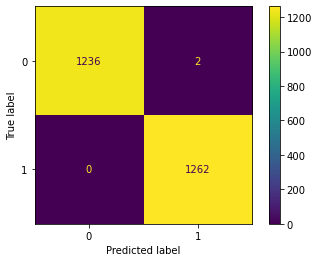

In [70]:
ConfusionMatrixDisplay.from_estimator(lr_full, bow_matrix_test, y_test)

# Reduced bag of words (2 best features)

In [75]:
keep_words = [':(', ':)']
bow_matrix_train = np.zeros((len(X_train_pp),len(keep_words)))
for i, tweet in enumerate(X_train_pp):
    for word in tweet:
        if word in keep_words:
            bow_matrix_train[i,keep_words.index(word)] += 1
            
# throw away tweets with none of these features
ind_has_feat = bow_matrix_train.sum(axis=1)>0
bow_matrix_train_red = bow_matrix_train[ind_has_feat,:]
y_train_red = y_train[ind_has_feat]

bow_matrix_train_red.shape

(5976, 2)

In [76]:
np.sum(bow_matrix_train!=0)/np.prod(bow_matrix_train.shape)

0.3984

# Reduced test data

In [ ]:
bow_matrix_test = np.zeros((len(X_test_pp),len(keep_words)))
for i, tweet in enumerate(X_test_pp):
    for word in tweet:
        if word in keep_words:
            bow_matrix_test[i,keep_words.index(word)] += 1
            
# throw away tweets with none of these features
ind_has_feat = bow_matrix_test.sum(axis=1)>0
bow_matrix_test_red = bow_matrix_test[ind_has_feat,:]
y_test_red = y_test[ind_has_feat]

sum(~ind_has_feat), bow_matrix_test_red.shape

# Reduced logistic regression

In [ ]:
lr_red = LogisticRegression() \
    .fit(bow_matrix_train_red,y_train_red) 

In [ ]:
MultinomialNB(alpha=1.0, fit_prior=False) \
    .fit(bow_matrix_train_red,y_train_red) \
    .score(bow_matrix_test_red, y_test_red)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr_red, bow_matrix_test_red, y_test_red)

# Words only

In [ ]:
alpha_words = [word for word in unique_words if word.isalpha()]
len(alpha_words), len(unique_words)

## Train and test data

In [ ]:
bow_matrix_train = np.zeros((len(X_train_pp),len(alpha_words)))
for i, tweet in enumerate(X_train_pp):
    for word in tweet:
        if word in alpha_words:
            bow_matrix_train[i,alpha_words.index(word)] += 1
            
            
# throw away tweets with none of these features
ind_has_feat = bow_matrix_train.sum(axis=1)>0
bow_matrix_train_words = bow_matrix_train[ind_has_feat,:]
y_train_words = y_train[ind_has_feat]

In [ ]:
bow_matrix_test = np.zeros((len(X_test_pp),len(alpha_words)))
for i, tweet in enumerate(X_test_pp):
    for word in tweet:
        if word in alpha_words:
            bow_matrix_test[i,alpha_words.index(word)] += 1
            
# throw away tweets with none of these features
ind_has_feat = bow_matrix_test.sum(axis=1)>0
bow_matrix_test_words = bow_matrix_test[ind_has_feat,:]
y_test_words = y_test[ind_has_feat]

sum(~ind_has_feat), bow_matrix_test_red.shape

## Logistic regression

In [ ]:
lr_alpha = LogisticRegression() \
    .fit(bow_matrix_train_words,y_train_words) 

In [ ]:
MultinomialNB(alpha=1.0, fit_prior=False) \
    .fit(bow_matrix_train_words,y_train_words) \
    .score(bow_matrix_test_words, y_test_words)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr_alpha, bow_matrix_test_words, y_test_words)

In [ ]:
ind = np.argsort(lr_alpha.coef_[0])
print([alpha_words[i] for i in ind[:5]])
print([alpha_words[i] for i in ind[-5:]])

In [ ]:

n = 10
plt.figure(figsize=(15,5))
plt.bar([alpha_words[i] for i in ind[:n]], lr_alpha.coef_[0,ind[:n]])
plt.xticks(fontsize=14)

plt.figure(figsize=(15,5))
plt.bar([alpha_words[i] for i in ind[-n:]], lr_alpha.coef_[0,ind[-n:]])
plt.xticks(fontsize=14)
plt.show()

# TF IDF